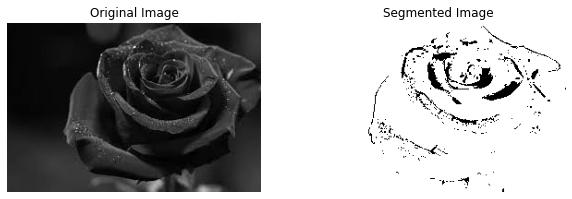

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def region_growing(image, seed, threshold):
    # Initialize the segmentation result
    segmented_image = np.zeros_like(image)
    height, width = image.shape[:2]

    # List of points to be checked
    check_points = [seed]

    # List of directions for 8-connected neighbors
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

    while check_points:
        x, y = check_points.pop(0)

        # Avoid re-checking points
        if segmented_image[y, x] != 0:
            continue

        # Mark the current point as part of the region
        segmented_image[y, x] = 255

        # Check the neighbors
        for dx, dy in directions:
            nx, ny = x + dx, y + dy

            # Ensure the neighbor is within the image boundaries
            if 0 <= nx < width and 0 <= ny < height:
                # Calculate the intensity difference
                if abs(int(image[ny, nx]) - int(image[y, x])) < threshold:
                    # Add the neighbor to the list of points to be checked
                    check_points.append((nx, ny))

    return segmented_image

# Load the image
image = cv2.imread('rose.jpg', cv2.IMREAD_GRAYSCALE)

# Define the seed point and threshold
seed_point = (100, 100)  # Example seed point
threshold_value = 10  # Example threshold value

# Apply region growing
segmented_result = region_growing(image, seed_point, threshold_value)

# Display the original and segmented images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_result, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')

plt.show()


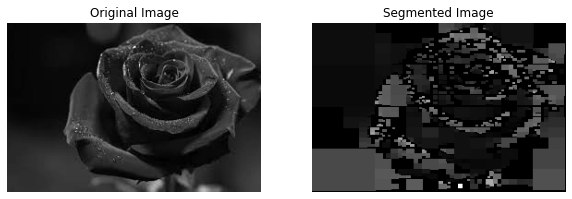

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def split_and_merge(image, threshold):
    def split(image, x, y, w, h, threshold):
        # Base case: if the region is smaller than 1x1, return the region
        if w <= 1 or h <= 1:
            return [(x, y, w, h)]
        
        # Calculate the mean and standard deviation of the region
        region = image[y:y+h, x:x+w]
        mean, stddev = cv2.meanStdDev(region)
        
        # If the standard deviation is less than the threshold, return the region
        if stddev[0][0] < threshold:
            return [(x, y, w, h)]
        
        # Otherwise, split the region into four subregions
        half_w, half_h = w // 2, h // 2
        regions = []
        regions.extend(split(image, x, y, half_w, half_h, threshold))
        regions.extend(split(image, x + half_w, y, half_w, half_h, threshold))
        regions.extend(split(image, x, y + half_h, half_w, half_h, threshold))
        regions.extend(split(image, x + half_w, y + half_h, half_w, half_h, threshold))
        
        return regions
    
    def merge(regions, image, threshold):
        def find_neighbors(regions, region):
            neighbors = []
            x, y, w, h = region
            for (nx, ny, nw, nh) in regions:
                if (nx == x + w or nx + nw == x) and ny == y and nh == h:
                    neighbors.append((nx, ny, nw, nh))
                elif (ny == y + h or ny + nh == y) and nx == x and nw == w:
                    neighbors.append((nx, ny, nw, nh))
            return neighbors
        
        merged = np.zeros_like(image, dtype=np.uint8)
        for region in regions:
            x, y, w, h = region
            neighbors = find_neighbors(regions, region)
            region_mean = np.mean(image[y:y+h, x:x+w])
            merge_region = True
            for neighbor in neighbors:
                nx, ny, nw, nh = neighbor
                neighbor_mean = np.mean(image[ny:ny+nh, nx:nx+nw])
                if abs(region_mean - neighbor_mean) > threshold:
                    merge_region = False
                    break
            if merge_region:
                cv2.rectangle(merged, (x, y), (x+w, y+h), int(region_mean), cv2.FILLED)
        return merged

    # Split the image
    height, width = image.shape
    regions = split(image, 0, 0, width, height, threshold)

    # Merge the regions
    merged_image = merge(regions, image, threshold)
    
    return merged_image

# Load the image
image = cv2.imread('rose.jpg', cv2.IMREAD_GRAYSCALE)

# Define the threshold
threshold_value = 10  # Example threshold value

# Apply region splitting and merging
segmented_result = split_and_merge(image, threshold_value)

# Display the original and segmented images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_result, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')

plt.show()


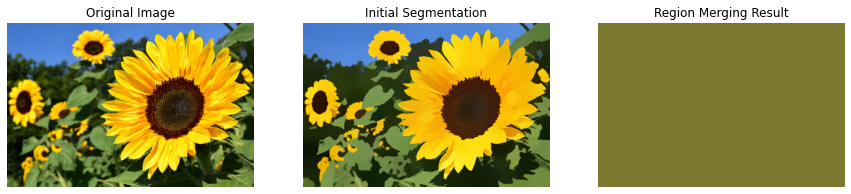

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def initial_segmentation(image, spatial_radius=21, color_radius=51):
    """
    Perform initial segmentation using mean shift filtering.
    """
    return cv2.pyrMeanShiftFiltering(image, sp=spatial_radius, sr=color_radius)

def merge_regions(image, labels, threshold):
    """
    Merge regions based on color similarity.
    """
    height, width = image.shape[:2]
    segmented_image = np.zeros_like(image)
    
    # Create a dictionary to store mean colors of regions
    mean_colors = {}
    
    for y in range(height):
        for x in range(width):
            label = labels[y, x]
            if label not in mean_colors:
                mean_colors[label] = []
            mean_colors[label].append(image[y, x])
    
    for label in mean_colors:
        mean_colors[label] = np.mean(mean_colors[label], axis=0)
    
    def find_neighbors(labels, label):
        neighbors = set()
        for y in range(height):
            for x in range(width):
                if labels[y, x] == label:
                    for dy in range(-1, 2):
                        for dx in range(-1, 2):
                            if 0 <= y+dy < height and 0 <= x+dx < width:
                                neighbor_label = labels[y+dy, x+dx]
                                if neighbor_label != label:
                                    neighbors.add(neighbor_label)
        return neighbors
    
    def merge(label, neighbors):
        region_color = mean_colors[label]
        for neighbor in neighbors:
            neighbor_color = mean_colors[neighbor]
            if np.linalg.norm(region_color - neighbor_color) < threshold:
                labels[labels == neighbor] = label
                mean_colors[label] = (mean_colors[label] + mean_colors[neighbor]) / 2
                del mean_colors[neighbor]
    
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        neighbors = find_neighbors(labels, label)
        merge(label, neighbors)
    
    for y in range(height):
        for x in range(width):
            segmented_image[y, x] = mean_colors[labels[y, x]]
    
    return segmented_image

# Load the image
image = cv2.imread('sunflower.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform initial segmentation
initial_segmented = initial_segmentation(image)

# Convert the initial segmentation result to labels
_, labels = cv2.connectedComponents(cv2.cvtColor(initial_segmented, cv2.COLOR_RGB2GRAY).astype(np.uint8))

# Define the threshold for merging regions
threshold_value = 30  # Example threshold value

# Merge the regions
merged_result = merge_regions(image, labels, threshold_value)

# Display the original, initial segmented, and final merged images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(initial_segmented)
plt.title('Initial Segmentation')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(merged_result)
plt.title('Region Merging Result')
plt.axis('off')

plt.show()


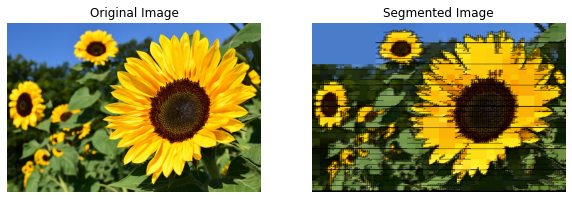

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def split(image, x, y, w, h, threshold):
    """
    Recursively split the image into regions based on a homogeneity criterion.
    """
    region = image[y:y+h, x:x+w]
    mean, stddev = cv2.meanStdDev(region)[:2]
    
    # If the region is homogeneous enough, return the region
    if stddev[0] < threshold:
        return [(x, y, w, h)]
    
    # If the region is too small to split, return the region
    if w <= 1 or h <= 1:
        return [(x, y, w, h)]
    
    # Otherwise, split the region into four subregions
    half_w, half_h = w // 2, h // 2
    regions = []
    regions.extend(split(image, x, y, half_w, half_h, threshold))
    regions.extend(split(image, x + half_w, y, half_w, half_h, threshold))
    regions.extend(split(image, x, y + half_h, half_w, half_h, threshold))
    regions.extend(split(image, x + half_w, y + half_h, half_w, half_h, threshold))
    
    return regions

def merge(image, regions, threshold):
    """
    Merge similar adjacent regions.
    """
    labels = np.zeros((image.shape[0], image.shape[1]), np.int32)
    current_label = 1

    for region in regions:
        x, y, w, h = region
        labels[y:y+h, x:x+w] = current_label
        current_label += 1

    merged = np.zeros_like(image, dtype=np.uint8)
    
    for i in range(1, current_label):
        mask = labels == i
        mean_color = cv2.mean(image, mask.astype(np.uint8))[:3]
        merged[mask] = mean_color

    return merged

def split_and_merge(image, threshold):
    """
    Perform region splitting and merging on the image.
    """
    height, width = image.shape[:2]
    regions = split(image, 0, 0, width, height, threshold)
    merged_image = merge(image, regions, threshold)
    return merged_image

# Load the image
image = cv2.imread('sunflower.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define the threshold for homogeneity
threshold_value = 10  # Example threshold value

# Apply region splitting and merging
segmented_result = split_and_merge(image, threshold_value)

# Display the original and segmented images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_result)
plt.title('Segmented Image')
plt.axis('off')

plt.show()


In [16]:
import sys
project_root = 'C:\\Users\\User'  # Replace with your actual project root path

# Add the project root to sys.path
sys.path.append(project_root)

import cv2
from segmentation.region_growing import Region_Growing


import pydicom
import os, sys, getopt

DICOM_IMAGE_EXT = '.dcm'
OTHER_IMAGE_EXT = ['.jpg','.png', '.jpeg']
IMAGE_PATH = 'sunflower.jpg' # Default image path
CONN = 4

def run_region_growing_on_image(image_path):
	"""
	1. Load Image in grayscale
	2. Segment the image using region growing and user seeds
	3. Display the result and ask for additional seeds
	4. Repeat Steps 2-3 until user presses Esc

	PS: Press Esc to exit from segmentation
	"""
	image_data, image_name = get_image_data(image_path)

	image_data = resize_image(image_data)

	image_data_post_smoothing = apply_gaussian_smoothing(image_data)

	region_growing(image_data_post_smoothing, segmentation_name=image_name+ " segmentation", neighbours=CONN)


def region_growing(image_data, neighbours, threshold=10, segmentation_name="Region Growing"):
	region_growing = Region_Growing(image_data, threshold=threshold, conn=neighbours)
	# Set Seeds
	region_growing.set_seeds()
	# Segmentation
	region_growing.segment()
	# Display Segmentation
	region_growing.display_and_resegment(name=segmentation_name)


def get_image_data(image_path):
    name, ext = os.path.splitext(image_path)
    if ext == DICOM_IMAGE_EXT:
        return (pydicom.read_file(image_path).pixel_array, name)
    elif ext in OTHER_IMAGE_EXT:
        image_data = cv2.imread(image_path, 0)
        if image_data is None:
            print(f"Error: Unable to read image from {image_path}")
            sys.exit()
        return (image_data, name)
    else:
        print(f"Invalid Image Format. Supported Image Formats are: {DICOM_IMAGE_EXT}, {OTHER_IMAGE_EXT}")
        sys.exit()



def resize_image(image_data):
	if image_data.shape[0]>1000:
		image_data = cv2.resize(image_data, (0,0), fx=0.25, fy=0.25)
	if image_data.shape[0]>500:
		image_data = cv2.resize(image_data, (0,0), fx=0.5, fy=0.5)
	return image_data


def apply_gaussian_smoothing(image_data, filter_size=3):
	return cv2.GaussianBlur(image_data,(filter_size,filter_size),0)


import sys
import getopt

def set_cmd_line_arguments():
    global IMAGE_PATH
    global CONN
    
    # Filter out the arguments passed by Jupyter Notebook
    argv = [arg for arg in sys.argv[1:] if not arg.startswith("-")]
    
    if len(argv) == 0:
        print("No image path specified. TERMINATING!!")
        sys.exit()
    
    opts, args = getopt.getopt(argv, "", ["image_path=", "conn="])
    for opt, arg in opts:
        if opt == "--image_path":
            IMAGE_PATH = arg
        elif opt == "--conn":
            CONN = int(arg)
        else:
            print("Make sure to spell 'image_path' correctly")
            sys.exit()
    
    print("Image Path:", IMAGE_PATH)



if __name__ == "__main__":
	set_cmd_line_arguments()
	run_region_growing_on_image(IMAGE_PATH)

Image Path: sunflower.jpg


ValueError: chr() arg not in range(0x110000)

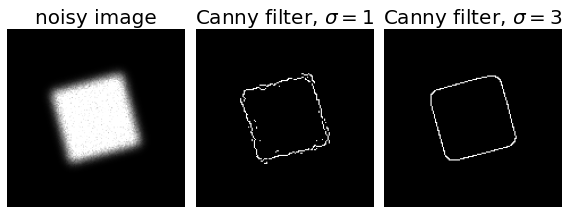

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.util import random_noise
from skimage import feature


# Generate noisy image of a square
image = np.zeros((128, 128), dtype=float)
image[32:-32, 32:-32] = 1

image = ndi.rotate(image, 15, mode='constant')
image = ndi.gaussian_filter(image, 4)
image = random_noise(image, mode='speckle', mean=0.1)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(image)
edges2 = feature.canny(image, sigma=3)

# display results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('noisy image', fontsize=20)

ax[1].imshow(edges1, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax[2].imshow(edges2, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=3$', fontsize=20)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'histogram of gray values')

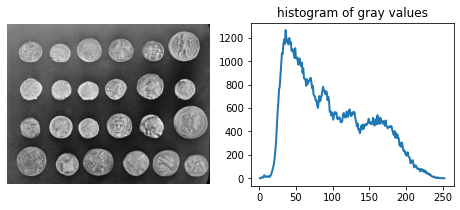

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.exposure import histogram

coins = data.coins()
hist, hist_centers = histogram(coins)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(coins, cmap=plt.cm.gray)
axes[0].set_axis_off()
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('histogram of gray values')

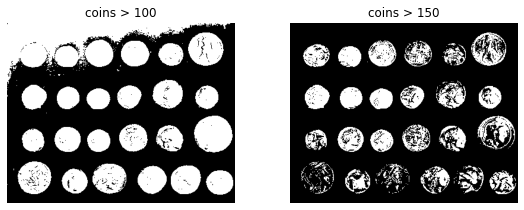

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

axes[0].imshow(coins > 100, cmap=plt.cm.gray)
axes[0].set_title('coins > 100')

axes[1].imshow(coins > 150, cmap=plt.cm.gray)
axes[1].set_title('coins > 150')

for a in axes:
    a.set_axis_off()

fig.tight_layout()

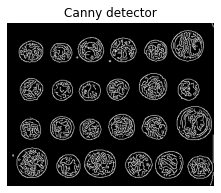

In [8]:
from skimage.feature import canny

edges = canny(coins)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(edges, cmap=plt.cm.gray)
ax.set_title('Canny detector')
ax.set_axis_off()

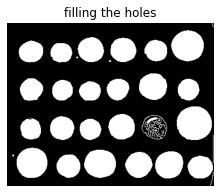

In [9]:
from scipy import ndimage as ndi

fill_coins = ndi.binary_fill_holes(edges)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(fill_coins, cmap=plt.cm.gray)
ax.set_title('filling the holes')
ax.set_axis_off()

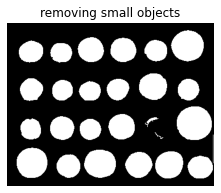

In [10]:
from skimage import morphology

coins_cleaned = morphology.remove_small_objects(fill_coins, 21)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(coins_cleaned, cmap=plt.cm.gray)
ax.set_title('removing small objects')
ax.set_axis_off()

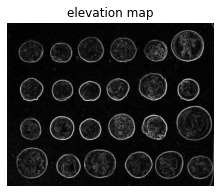

In [11]:
from skimage.filters import sobel

elevation_map = sobel(coins)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(elevation_map, cmap=plt.cm.gray)
ax.set_title('elevation map')
ax.set_axis_off()

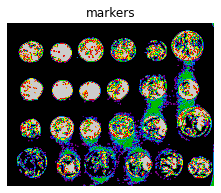

In [12]:
markers = np.zeros_like(coins)
markers[coins < 30] = 1
markers[coins > 150] = 2

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(markers, cmap=plt.cm.nipy_spectral)
ax.set_title('markers')
ax.set_axis_off()

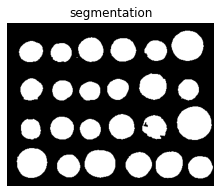

In [13]:
from skimage import segmentation

segmentation_coins = segmentation.watershed(elevation_map, markers)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(segmentation_coins, cmap=plt.cm.gray)
ax.set_title('segmentation')
ax.set_axis_off()

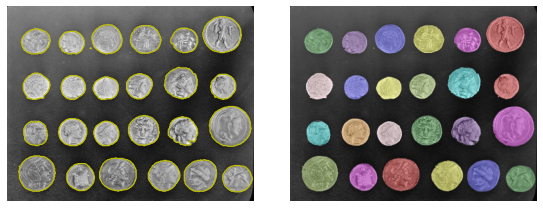

In [14]:
from skimage.color import label2rgb

segmentation_coins = ndi.binary_fill_holes(segmentation_coins - 1)
labeled_coins, _ = ndi.label(segmentation_coins)
image_label_overlay = label2rgb(labeled_coins, image=coins, bg_label=0)

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
axes[0].imshow(coins, cmap=plt.cm.gray)
axes[0].contour(segmentation_coins, [0.5], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay)

for a in axes:
    a.set_axis_off()

fig.tight_layout()

plt.show()